In [22]:
import tensorflow as tf
import os

import cv2
import imghdr

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [23]:
display(tf.config.list_physical_devices('CPU'))
display(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

[]

In [24]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# Remove dodgy images

In [25]:
data_dir = 'data1/hdd'
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [26]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [27]:
for img_class in os.listdir(data_dir):
    print(img_class)

0
1


# Load Data

In [28]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 915 files belonging to 2 classes.


In [29]:
data_iterator = data.as_numpy_iterator()

In [30]:
batch = data_iterator.next()
len(batch)

2

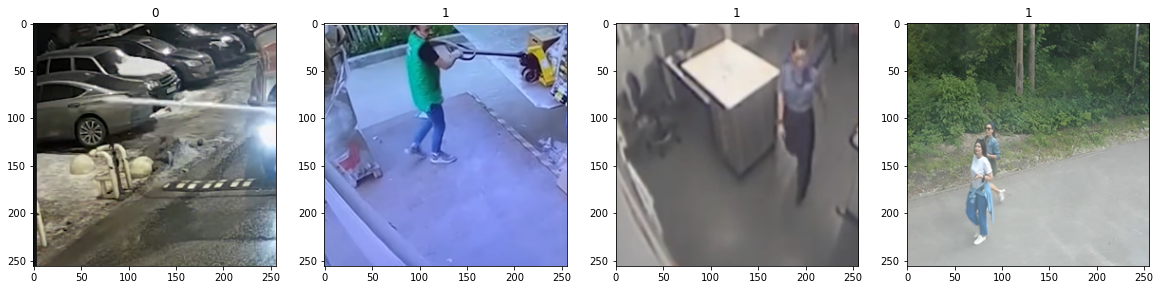

In [31]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Scale Data

In [32]:
data = data.map(lambda x,y: (x/255, y))

In [33]:
data.as_numpy_iterator().next()

(array([[[[0.4628488 , 0.4757049 , 0.52679265],
          [0.49284363, 0.5085299 , 0.56015766],
          [0.50809413, 0.51985884, 0.57289195],
          ...,
          [0.5514011 , 0.54355794, 0.6339037 ],
          [0.556583  , 0.54873985, 0.6393995 ],
          [0.55715394, 0.5493108 , 0.6395069 ]],
 
         [[0.5118143 , 0.52679956, 0.57025886],
          [0.49846706, 0.51078653, 0.5539205 ],
          [0.4736024 , 0.48915374, 0.530606  ],
          ...,
          [0.53625625, 0.5358839 , 0.62608   ],
          [0.54004616, 0.5394947 , 0.62969077],
          [0.5387904 , 0.53786   , 0.62805605]],
 
         [[0.4666437 , 0.480292  , 0.513078  ],
          [0.46259192, 0.47585785, 0.50927836],
          [0.4637791 , 0.47946537, 0.5117571 ],
          ...,
          [0.522922  , 0.53214616, 0.6186145 ],
          [0.5297305 , 0.53817403, 0.62444854],
          [0.52464765, 0.5341222 , 0.6218102 ]],
 
         ...,
 
         [[0.706871  , 0.63957983, 0.6003641 ],
          [0.71780

# Split Data

In [34]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [35]:
train_size

20

In [36]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Build Deep Learning Model

In [37]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [38]:
model = Sequential()

In [39]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [40]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

# Train

In [42]:
logdir='logs'

In [43]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [44]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
20/20 [==============================] - 21s 912ms/step - loss: 0.8246 - accuracy: 0.5266 - val_loss: 0.6907 - val_accuracy: 0.5750
Epoch 2/20
20/20 [==============================] - 18s 839ms/step - loss: 0.6675 - accuracy: 0.6172 - val_loss: 0.6334 - val_accuracy: 0.6500
Epoch 3/20
20/20 [==============================] - 22s 1s/step - loss: 0.6239 - accuracy: 0.6500 - val_loss: 0.5928 - val_accuracy: 0.6687
Epoch 4/20
20/20 [==============================] - 20s 956ms/step - loss: 0.5685 - accuracy: 0.7031 - val_loss: 0.5564 - val_accuracy: 0.7188
Epoch 5/20
20/20 [==============================] - 20s 954ms/step - loss: 0.4644 - accuracy: 0.7750 - val_loss: 0.5377 - val_accuracy: 0.7312
Epoch 6/20
20/20 [==============================] - 19s 872ms/step - loss: 0.3660 - accuracy: 0.8328 - val_loss: 0.4579 - val_accuracy: 0.7937
Epoch 7/20
20/20 [==============================] - 18s 870ms/step - loss: 0.2900 - accuracy: 0.8781 - val_loss: 0.4975 - val_accuracy: 0.8000
Ep

# Plot Performance

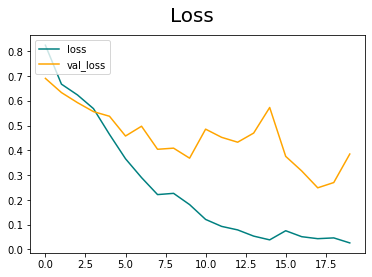

In [45]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

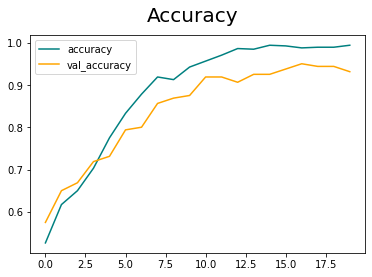

In [46]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate

In [47]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [48]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 237ms/step


In [49]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.9736842, shape=(), dtype=float32) tf.Tensor(0.925, shape=(), dtype=float32) tf.Tensor(0.9375, shape=(), dtype=float32)


# Test

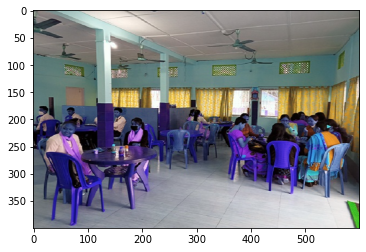

In [99]:
img = cv2.imread('C:/Users/Jegadit/Desktop/root/pah/works/python/AmritaCanteenApp/Table/data2/emptyFilled/filledTable\Canteen_2.jpg')
plt.imshow(img)
plt.show()

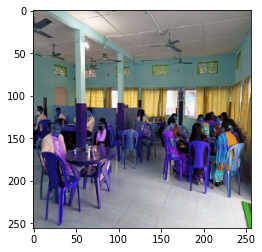

In [100]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [101]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 48ms/step


In [102]:
yhat

array([[0.9999169]], dtype=float32)

In [103]:
if yhat > 0.5:
    print(f'Person detected')
else:
    print(f'Person not detected')

Person detected
